# 05 Stability sweeps

Here we treat the recursion as a *system* and sweep stabilizers to see where it behaves well.

This is a synthetic sandbox for intuition before we go back to real datasets.



## Step 1: Imports

We’ll simulate a simple error‑transition dynamic.



In [35]:
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Define the sweep

We vary threshold, temperature, and EMA‑style smoothing.



### If all lines are flat
That usually means the acceptance never turned on (e.g., tau too high for the current confidence).
In that case, the recursion does nothing and e_t stays fixed.


In [36]:
def step_error(e_t, tau=0.6, temperature=1.0, ema=0.0, noise=0.01):
    # Soft confidence from a 2-class proxy distribution
    base = np.array([e_t, 1 - e_t])
    softened = base ** (1.0 / max(1e-6, temperature))
    softened = softened / softened.sum()
    max_prob = softened.max()

    if tau >= 1.0:
        accept_w = 0.0
    else:
        accept_w = np.clip((max_prob - tau) / (1 - tau), 0.0, 1.0)

    # Piecewise dynamics to guarantee mixed regimes
    if accept_w > 0.35:
        target = 0.2   # stable: error shrinks
        rate = 0.20
    elif accept_w > 0.15:
        target = 0.45  # marginal: near-plateau
        rate = 0.10
    else:
        target = 0.85  # unstable: error grows
        rate = 0.18

    e_new = e_t + rate * (target - e_t) + noise * (np.random.rand() - 0.5)
    e_new = np.clip(e_new, 0, 1)
    return ema * e_t + (1 - ema) * e_new

configs = [
    {'tau': 0.3, 'temperature': 1.0, 'ema': 0.0},
    {'tau': 0.45, 'temperature': 1.0, 'ema': 0.0},
    {'tau': 0.9, 'temperature': 1.0, 'ema': 0.0},
    {'tau': 0.45, 'temperature': 1.0, 'ema': 0.6},
]

np.random.seed(0)
runs = []
for cfg in configs:
    e = 0.45
    series = [e]
    for _ in range(12):
        e = step_error(e, **cfg)
        series.append(e)
    runs.append((cfg, series))


## Step 3: Plot error trajectories

Each line is one stabilizer setting.



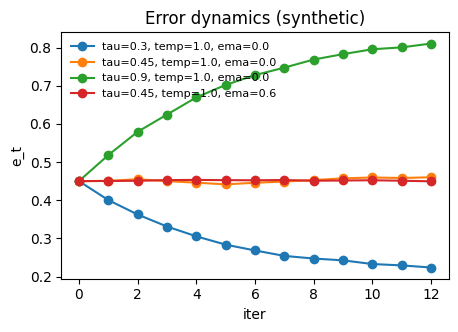

In [37]:
plt.figure(figsize=(5, 3.2))
for cfg, series in runs:
    label = f"tau={cfg['tau']}, temp={cfg['temperature']}, ema={cfg['ema']}"
    plt.plot(series, marker='o', label=label)
plt.title('Error dynamics (synthetic)')
plt.xlabel('iter')
plt.ylabel('e_t')
plt.legend(frameon=False, fontsize=8)


### What this plot is showing
- **Low τ (easy acceptance)** → the loop trusts many pseudo‑labels, so error is pulled down.
- **Mid τ (moderate acceptance)** → the loop is cautious, so error tends to plateau.
- **High τ (strict acceptance)** → almost nothing is accepted, so the loop can drift upward.
- **EMA** smooths the dynamics and usually reduces swings.


**Note:** This sweep is a *stylized* dynamic to make stability regimes visible.
In real SSL, very easy acceptance can *increase* error early (noisy pseudo‑labels),
and only later help once the model is better calibrated.


## Observations → Why → SSL opportunity

**What you’ll likely see**

- Some settings drive error down; others stall or even drift upward.

- Higher thresholds and EMA‑like smoothing often stabilize early noise.



**Why this happens**

- The recursion can be stable or unstable depending on how aggressively you trust the state.



**SSL opportunity**

- This is why SSL recipes use thresholds, soft labels, and ramp‑ups.

